## Общее описание:
Вы работаете аналитиком в приложении по доставке продуктов. Команда внедрила в приложение умную систему рекомендации товаров – предполагается, что такая система поможет пользователям эффективнее работать с приложением и лучше находить необходимые товары.

Чтобы проверить эффективность системы рекомендаций, был проведен АБ-тест. В группе 1 оказались пользователи с новой системой рекомендаций, в группе 0 пользователи со старой версией приложения, где нет рекомендации товаров.

### Задача
Ваша задача – оценить, смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения. Для этого нужно выбрать метрики, которые отвечают за качество сервиса, и статистически сравнить эти метрики в двух группах.

Результат вашей работы – аналитическое заключение с ответом на вопрос, стоит ли включать новую систему рекомендаций на всех пользователей

### Данные
-  `ab_users_data` – история заказов пользователей, в этой таблице есть информация о том, какие заказы создавали и отменяли пользователи
-  `
ab_order`  – подробная информация о составе заказа, тут для каждого заказа есть список id тех продуктов, которые были включен   заказ
-  `
ab_products` – подробная информация о продуктах, их название и стоимость

### Предобработка данных

In [107]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
import scipy.stats as st
import numpy as np
import lifelines as lf

In [108]:
orders = pd.read_csv(r"D:\учеба 2\Мага\Анализ данных\Карпов Аналитик данных\5. Статистика\ДЗ\10\ab_orders.csv")
products = pd.read_csv(r"D:\учеба 2\Мага\Анализ данных\Карпов Аналитик данных\5. Статистика\ДЗ\10\ab_products.csv")
users = pd.read_csv(r"D:\учеба 2\Мага\Анализ данных\Карпов Аналитик данных\5. Статистика\ДЗ\10\ab_users_data.csv")

In [109]:
orders.head() #посмотрим на данные

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"


In [110]:
orders.shape #посмотрим число строчек

(4123, 3)

In [111]:
products.head()

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0


In [112]:
products.shape 

(87, 3)

In [113]:
users.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1


In [114]:
users.shape

(4337, 6)

In [115]:
users.action.unique()

array(['create_order', 'cancel_order'], dtype=object)

### Гипотеза 1: изменилось число заказов на пользователя

In [117]:
# Уберем отмененные заказы
users_cancel_order = users.query("action == 'cancel_order'").order_id #заказы которые отменили
users['is_canceled'] = users['order_id'].isin(users_cancel_order).astype(int) #делаем переменную отмены заказа
users = users.query("action == 'create_order'") #отбираем только нужные строчки
users.head()

,user_id,order_id,action,time,date,group,is_canceled
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,0
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0,1
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1,0


In [118]:
users.shape

(4123, 7)

In [119]:
# Кол-во заказов в каждой группе 
users.groupby("group", as_index = False).size()

,group,size
0,0,1609
1,1,2514


In [120]:
# Число заказов на юзера
ord_per_users = users.groupby(['group','user_id'], as_index = False).size()
ord_per_users.head()

,group,user_id,size
0,0,964,2
1,0,966,1
2,0,968,3
3,0,969,2
4,0,972,1


<Axes: xlabel='size', ylabel='count'>

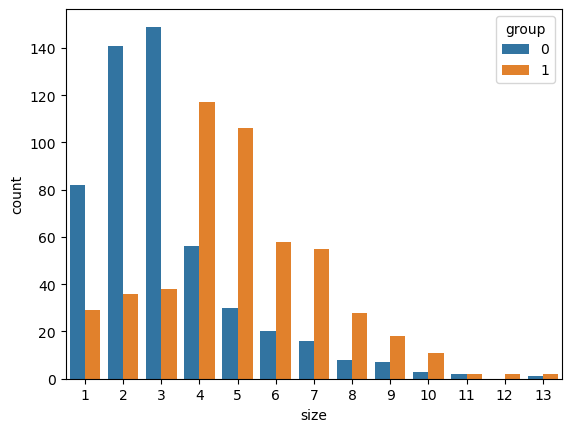

In [121]:
# преобразую в строку тк выдает ошибку "'numpy.int64' object has no attribute 'startswith'"
ord_per_users_str = ord_per_users
ord_per_users_str['group'] = ord_per_users_str['group'].astype(str) 
sns.countplot(data=ord_per_users_str, x = 'size', hue = 'group') #countplot тк сильно выраженные дискретные данные и гистограмма будет выглядеть плохо

Заметно смещение в сторону большего кол-во заказов в тестовой группе

In [123]:
# Проверим статистически
pg.ttest(x = ord_per_users.query('group == "0"')['size'],
       y = ord_per_users.query('group == "1"')['size'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-14.485157,988.435475,two-sided,2.907783e-43,"[-2.14, -1.63]",0.910119,7.663e+39,1.0


p-value близка к 0, следовательно нулевая гипотеза отклоняется, статистическое различие между группами есть

In [125]:
pg.mwu(x = ord_per_users.query('group == "0"')['size'],
       y = ord_per_users.query('group == "1"')['size'])

,U-val,alternative,p-val,RBC,CLES
MWU,61172.5,two-sided,6.987140e-49,0.526767,0.236617


Вероятность того, что у случайного пользователя из первой группы заказов будет больше, чем у пользователя из второй, составляет порядка 24%, что меньше 50%. Следовательно, можно заключить, что эти группы различаются.

### Гипотеза 2: Изменилась пропорция отмен

In [128]:
pd.crosstab(users.group, users.is_canceled)

is_canceled,0,1
group,,
0,1527,82
1,2382,132


Является ли увеличение отмен заказов стат. значимым?

In [130]:
exp, obs, stats = pg.chi2_independence(data = users, x = "group", y = 'is_canceled')
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,0.021274,1.0,0.884034,0.002272,0.052441
1,cressie-read,0.666667,0.021284,1.0,0.884008,0.002272,0.052442
2,log-likelihood,0.000000,0.021304,1.0,0.883954,0.002273,0.052444
3,freeman-tukey,-0.500000,0.021319,1.0,0.883914,0.002274,0.052446
4,mod-log-likelihood,-1.000000,0.021334,1.0,0.883873,0.002275,0.052447
5,neyman,-2.000000,0.021364,1.0,0.883791,0.002276,0.052451


ТК p-value больше 0.05, то нулевая принимается, следовательно стат. различий нет, увеличение отмен обосновано только увеличением общего кол-во заказов и не связано с изменением в тестовой группе

### Гипотеза 3: изменилось число позиций в заказе

In [133]:
ord_content = users[['user_id', 'order_id', 'group']].merge(orders)
ord_content.head()

,user_id,order_id,group,creation_time,product_ids
0,964,1255,0,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,965,1256,1,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,964,1257,0,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,966,1258,0,2022-08-26 00:02:56.000000,"{74, 6}"
4,967,1259,1,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"


In [134]:
#развернем список продуктов
ord_content["product_ids"] = ord_content.product_ids.str.strip('{}').str.split(', ')
ord_content_expl = ord_content.explode('product_ids')

In [135]:
ord_content_expl.head()

,user_id,order_id,group,creation_time,product_ids
0,964,1255,0,2022-08-26 00:00:19.000000,75
0,964,1255,0,2022-08-26 00:00:19.000000,22
0,964,1255,0,2022-08-26 00:00:19.000000,53
0,964,1255,0,2022-08-26 00:00:19.000000,84
1,965,1256,1,2022-08-26 00:02:21.000000,56


Число позиций в заказе

In [137]:
item_per_order = ord_content_expl.groupby(['group','order_id'], as_index=False).size()
item_per_order.head()

,group,order_id,size
0,0,1255,4
1,0,1257,4
2,0,1258,2
3,0,1261,4
4,0,1262,4


<Axes: xlabel='size', ylabel='count'>

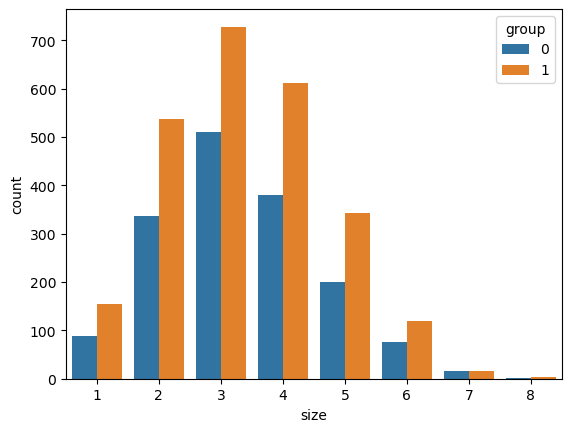

In [138]:
# преобразую в строку тк выдает ошибку "'numpy.int64' object has no attribute 'startswith'"
item_per_order_str = item_per_order
item_per_order_str['group'] = item_per_order_str['group'].astype(str) 
sns.countplot(data=item_per_order, x='size', hue = 'group')

Визуально распределения не выглядят сильно отличающимися, заметно только разница в высоте, но это обусловлено общим увеличением заказов

Проверим тестами

In [140]:
pg.ttest(x = item_per_order.query('group == "0"')['size'],
         y = item_per_order.query('group == "1"')['size'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.138556,3469.224056,two-sided,0.889809,"[-0.09, 0.07]",0.004407,0.036,0.052185


p-val больше 5%, следовательно, нулевая отклоняется, стат различий нет

In [142]:
pg.mwu(x = item_per_order.query('group == "0"')['size'],
         y = item_per_order.query('group == "1"')['size'])

,U-val,alternative,p-val,RBC,CLES
MWU,2013211.0,two-sided,0.79766,0.004599,0.4977


Второй тест показал аналогичный результат (тк CLES примерно 50%)

### Гипотеза 4: Изменилась стоимость заказа

In [145]:
products.head()

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0


In [146]:
products.dtypes

product_id      int64
name           object
price         float64
dtype: object

In [147]:
ord_content_expl.head()

,user_id,order_id,group,creation_time,product_ids
0,964,1255,0,2022-08-26 00:00:19.000000,75
0,964,1255,0,2022-08-26 00:00:19.000000,22
0,964,1255,0,2022-08-26 00:00:19.000000,53
0,964,1255,0,2022-08-26 00:00:19.000000,84
1,965,1256,1,2022-08-26 00:02:21.000000,56


In [148]:
ord_content_expl.dtypes

user_id           int64
order_id          int64
group             int64
creation_time    object
product_ids      object
dtype: object

In [149]:
ord_content_expl['product_ids'] = ord_content_expl['product_ids'].astype(np.int64)

In [150]:
ord_price = ord_content_expl.merge(products, left_on='product_ids', right_on='product_id')
ord_price.sort_values('order_id')

,user_id,order_id,group,creation_time,product_ids,product_id,name,price
0,964,1255,0,2022-08-26 00:00:19.000000,75,75,сок ананасовый,120.0
371,964,1255,0,2022-08-26 00:00:19.000000,84,84,мандарины,90.4
205,964,1255,0,2022-08-26 00:00:19.000000,53,53,мука,78.3
118,964,1255,0,2022-08-26 00:00:19.000000,22,22,сок мультифрукт,120.0
837,965,1256,1,2022-08-26 00:02:21.000000,76,76,чай черный в пакетиках,55.5
...,...,...,...,...,...,...,...,...
12287,1461,59487,0,2022-09-08 23:29:06.000000,9,9,чай черный листовой,83.5
12142,1461,59487,0,2022-09-08 23:29:06.000000,62,62,сок яблочный,120.0
8633,1461,59487,0,2022-09-08 23:29:06.000000,77,77,курица,298.4
8097,1376,59533,0,2022-09-08 23:41:24.000000,17,17,морс брусничный,190.0


In [151]:
value_per_order = ord_price.groupby(['group','order_id'], as_index=False).price.sum()
value_per_order.head()

,group,order_id,price
0,0,1255,408.7
1,0,1257,310.2
2,0,1258,85.0
3,0,1261,430.7
4,0,1262,358.6


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='price', ylabel='Count'>

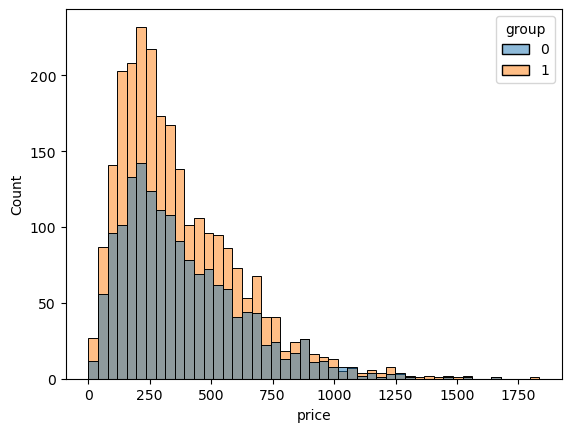

In [152]:
sns.histplot(data=value_per_order, x='price', hue='group')

Визуально не наблюдаются различия в распределении

In [154]:
pg.ttest(x = value_per_order.query('group == 0')['price'],
         y = value_per_order.query('group == 1')['price'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.483514,3441.720793,two-sided,0.13803,"[-3.75, 27.08]",0.047301,0.108,0.316351


p-val > 0.05 нулевая отклоняется, различий нет

In [156]:
pg.mwu(x = value_per_order.query('group == 0')['price'],
         y = value_per_order.query('group == 1')['price'])

,U-val,alternative,p-val,RBC,CLES
MWU,2089851.0,two-sided,0.070912,-0.033294,0.516647


Второй тест подтверждает 

### Гипотеза 5: Изменились ли характеристики ретеншена

In [159]:
ord_content.head()

,user_id,order_id,group,creation_time,product_ids
0,964,1255,0,2022-08-26 00:00:19.000000,"[75, 22, 53, 84]"
1,965,1256,1,2022-08-26 00:02:21.000000,"[56, 76, 39]"
2,964,1257,0,2022-08-26 00:02:27.000000,"[76, 34, 41, 38]"
3,966,1258,0,2022-08-26 00:02:56.000000,"[74, 6]"
4,967,1259,1,2022-08-26 00:03:37.000000,"[20, 45, 67, 26]"


In [160]:
ord_content['creation_time'] = pd.to_datetime(ord_content.creation_time)
ord_content.head()

,user_id,order_id,group,creation_time,product_ids
0,964,1255,0,2022-08-26 00:00:19,"[75, 22, 53, 84]"
1,965,1256,1,2022-08-26 00:02:21,"[56, 76, 39]"
2,964,1257,0,2022-08-26 00:02:27,"[76, 34, 41, 38]"
3,966,1258,0,2022-08-26 00:02:56,"[74, 6]"
4,967,1259,1,2022-08-26 00:03:37,"[20, 45, 67, 26]"


In [161]:
#длительность A/B теста
ord_content.creation_time.max() - ord_content.creation_time.min()

Timedelta('13 days 23:41:05')

Время первого и последнего заказа

In [163]:
retention = ord_content.groupby(['user_id','group'], as_index=False).agg(
    first_order = ('creation_time','min'),
    last_order = ('creation_time','max'))
retention.head()

,user_id,group,first_order,last_order
0,964,0,2022-08-26 00:00:19,2022-08-26 00:02:27
1,965,1,2022-08-26 00:02:21,2022-09-04 22:24:32
2,966,0,2022-08-26 00:02:56,2022-08-26 00:02:56
3,967,1,2022-08-26 00:03:37,2022-08-28 16:41:30
4,968,0,2022-08-26 00:05:35,2022-08-31 05:27:34


In [164]:
(retention.last_order - retention.first_order).describe()

count                         1017
mean     6 days 23:27:21.923303834
std      4 days 06:43:22.480610835
min                0 days 00:00:00
25%                3 days 11:27:14
50%                7 days 15:39:20
75%               10 days 13:37:01
max               13 days 22:36:14
dtype: object

Время жизни пользователя (время между первый и последним заказом)

In [166]:
retention['lifetime'] = (retention.last_order - retention.first_order).dt.total_seconds() / (3600 * 24)
retention.head()
# сколько человек пробыл в нашем сервисе в днях

,user_id,group,first_order,last_order,lifetime
0,964,0,2022-08-26 00:00:19,2022-08-26 00:02:27,0.001481
1,965,1,2022-08-26 00:02:21,2022-09-04 22:24:32,9.932072
2,966,0,2022-08-26 00:02:56,2022-08-26 00:02:56,0.000000
3,967,1,2022-08-26 00:03:37,2022-08-28 16:41:30,2.692975
4,968,0,2022-08-26 00:05:35,2022-08-31 05:27:34,5.223600


In [167]:
retention.first_order.dt.date.unique() # все пользоватлеи из одной когорты

array([datetime.date(2022, 8, 26)], dtype=object)

Нужно определить точный критерий оттока испытуемых
Сделаем переменную оттока:

In [169]:
retention['churn'] = ((ord_content.creation_time.max()  - retention.last_order) > pd.Timedelta('7d')).astype(int)
retention.head()

,user_id,group,first_order,last_order,lifetime,churn
0,964,0,2022-08-26 00:00:19,2022-08-26 00:02:27,0.001481,1
1,965,1,2022-08-26 00:02:21,2022-09-04 22:24:32,9.932072,0
2,966,0,2022-08-26 00:02:56,2022-08-26 00:02:56,0.000000,1
3,967,1,2022-08-26 00:03:37,2022-08-28 16:41:30,2.692975,1
4,968,0,2022-08-26 00:05:35,2022-08-31 05:27:34,5.223600,1


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='lifetime', ylabel='Count'>

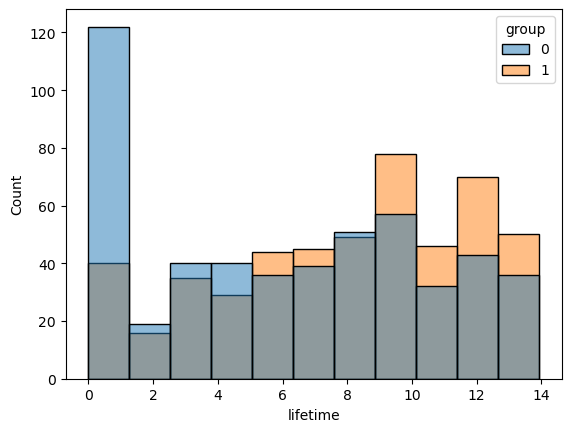

In [170]:
sns.histplot(data=retention, x='lifetime', hue='group')

В 0 группе много людей которые сделали один заказ и ушли

In [172]:
pg.ttest(x=retention.query('group == 0')['lifetime'],
         y=retention.query('group == 1')['lifetime'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-7.079732,1004.533039,two-sided,2.710044e-12,"[-2.37, -1.34]",0.443316,2.188e+09,1.0


In [173]:
pg.mwu(x=retention.query('group == 0')['lifetime'],
         y=retention.query('group == 1')['lifetime'])

,U-val,alternative,p-val,RBC,CLES
MWU,98354.0,two-sided,3.984586e-11,0.239129,0.380436


По резуьтатам тестов - группы различаются

In [175]:
pd.crosstab(retention.group, retention.churn)

churn,0,1
group,,
0,252,263
1,332,170


В 0 группе число покинувших и не покинувших примерно равно, в 1 иначе, больше людей остаются

In [177]:
exp, obs, stat = pg.chi2_independence(data = retention, x='group', y='churn')
stat

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,30.072727,1.0,4.161428e-08,0.171959,0.999787
1,cressie-read,0.666667,30.113482,1.0,4.074885e-08,0.172076,0.999790
2,log-likelihood,0.000000,30.250438,1.0,3.797055e-08,0.172467,0.999800
3,freeman-tukey,-0.500000,30.402505,1.0,3.510745e-08,0.172900,0.999810
4,mod-log-likelihood,-1.000000,30.597845,1.0,3.174461e-08,0.173454,0.999823
5,neyman,-2.000000,31.122750,1.0,2.422158e-08,0.174936,0.999852


Тест показал что в тестовой группе статистически значимо нас покидают меньше

Анализ выживаемости
(позволяет анализировать время до того, как случится (или не случится) событие)

In [180]:
kmf = lf.KaplanMeierFitter() #Создаем модель

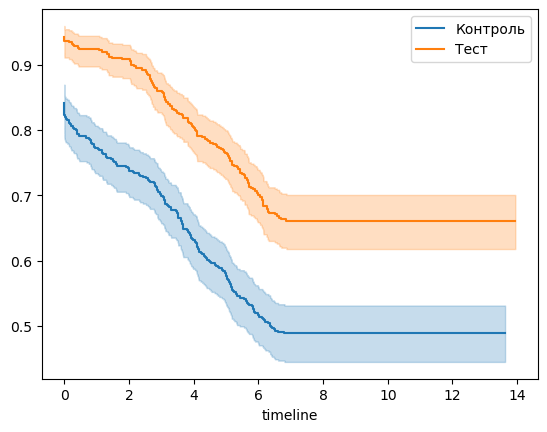

In [181]:
ax = plt.subplot(111) #чтобы поместить кривые на один римунок

kmf.fit(durations=retention.query('group == 0').lifetime, #длительность
        event_observed= retention.query('group == 0').churn, #событие
        label='Контроль') #строим модель
kmf.plot(ax=ax) #рисуем

kmf.fit(durations=retention.query('group == 1').lifetime,
        event_observed= retention.query('group == 1').churn,
        label='Тест') #строим модель
kmf.plot(ax=ax) #рисуем

plt.show()

Видим, как меняется вероятность, что пользователь останется, с течением времени. Плато образуется после 7-го дня, так как дальше нет ни одного человека, который нас покинул согласно критерию. Вероятность, что пользователь останется, в тестовой ощутимо выше, чем в контрольной. 

Это можно проверить статистически:

In [183]:
lf.statistics.logrank_test(durations_A=retention.query('group == 0').lifetime,
                           durations_B=retention.query('group == 1').lifetime,
                           event_observed_A= retention.query('group == 0').churn,
                           event_observed_B= retention.query('group == 1').churn)

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          37.41 <0.005     29.96

P-valur < 5% нулевая отклоняется, стат различие есть

Посчитаем эффект от введения новой системы рекомендаций

In [236]:
value_per_order.head()

,group,order_id,price
0,0,1255,408.7
1,0,1257,310.2
2,0,1258,85.0
3,0,1261,430.7
4,0,1262,358.6


In [246]:
value_per_order.groupby('group').agg({'price' : 'sum'})

,price
group,
0,613488.8
1,929232.0


In [250]:
round(929232.0/613488.8,2)

1.51

На основе проведенного анализа можно прийти к выводу, что введение новой системы рекомендации товара является целесообразным. В перспективе это позволит увеличить выручку на 50%.